# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
import pandas as pd

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [88]:
# (re-)load layers
%run homework_modules.ipynb


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

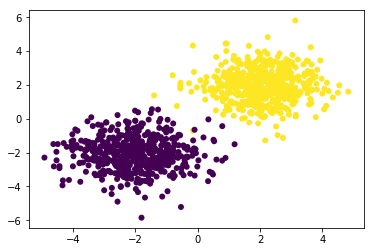

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

net = Sequential()
net.add(Linear(2, 8))
net.add(ReLU())
net.add(Linear(8, 2))
net.add(LogSoftMax())
net

Linear 2 -> 2
LogSoftMax



Linear 2 -> 8
ReLU
Linear 8 -> 2
LogSoftMax

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

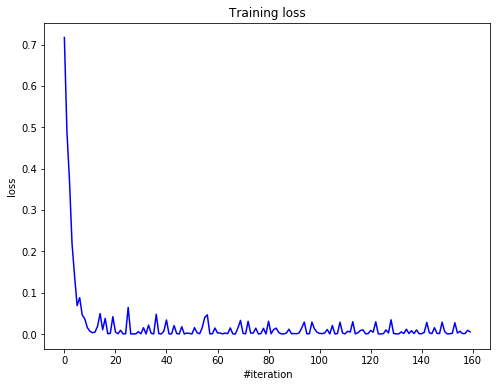

Current loss: 0.004903


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
preprots=OneHotEncoder(categories=[range(10)],sparse=False)
y_encoded=preprots.fit_transform(y_train.reshape(-1,1))
y_test_encoded=preprots.fit_transform(y_test.reshape(-1,1))
y_val_encoded=preprots.fit_transform(y_val.reshape(-1,1))

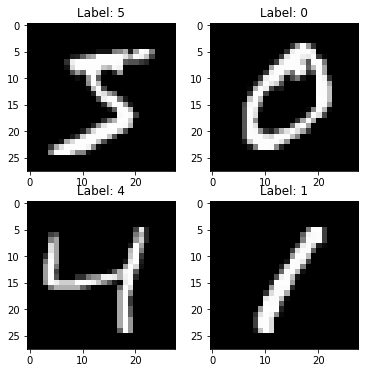

In [11]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


In [12]:
# Your code goes here. ################################################
def my_netty(activation):
    loss_history = []
    accuracy=[]
    optimizer_config = {'learning_rate' : 1e-1 , 'momentum': 0.9}
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(activation())
    net.add(Linear(256, 128))
    net.add(activation())
    net.add(Linear(128, 64)) 
    net.add(activation())
    net.add(Linear(64, 10))
    net.add(LogSoftMax())
    

    criterion = ClassNLLCriterion()
    n_epoch = 10
    batch_size = 256
    time_begin = time()
    for i in range(n_epoch):
        loss_epoch=[]
#         accuracy_epoch=[]
        for x_batch, y_batch in get_batches((X_train, y_encoded), batch_size):    
            net.zeroGradParameters()


            optimizer_state = {}

                # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

                # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

                # Update weights
            sgd_momentum(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state) 
            
            loss_epoch.append(loss)
            #Accuracy calculation
        net.evaluate()
        y_pred=net.forward(X_test)
        
        epoch_accuracy=accuracy_score(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred,axis=1))
        accuracy.append(epoch_accuracy)
        #accuracy_epoch.append(iter_accuracy)
        
            
#         accuracy.append(np.mean(accuracy_epoch))    
        loss_history.append(np.mean(loss_epoch))
    time_end = time()
    time_result=time_end-time_begin
            

    
    return loss_history,time_result,loss,accuracy

In [13]:
relu,time_relu,loss_relu,relu_accuracy=my_netty(ReLU)
Elu,time_elu,loss_elu,elu_accuracy=my_netty(ELU)
LRelu,time_lrelu,loss_lrelu,lrelu_accuracy=my_netty(LeakyReLU)
Softplus,time_softplus,loss_softplus,softplus_accuracy=my_netty(SoftPlus)

ReLU loss:  0.154 , ReLU time:  100.995 , ReLu accuracy:  0.9644
ELU loss:  0.142 , ELU time:  111.163 , ELU accuracy:  0.9453
LeakyReLU loss:  0.072 , LeakyReLU time:  89.44 , LeakyReLU accuracy 0.9616
SoftPlus loss:  0.388 , SoftPlus time:  104.877 , SoftPlus accuracy:  0.9104


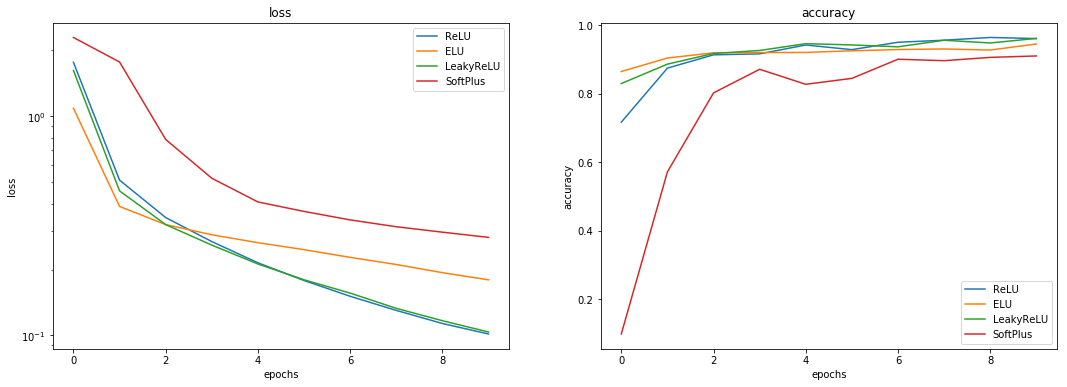

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.semilogy(relu,label='ReLU')
plt.semilogy(Elu,label='ELU')
plt.semilogy(LRelu,label='LeakyReLU')
plt.semilogy(Softplus,label='SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')
plt.subplot(122)
plt.plot(relu_accuracy,label='ReLU')
plt.plot(elu_accuracy,label='ELU')
plt.plot(lrelu_accuracy,label='LeakyReLU')
plt.plot(softplus_accuracy,label='SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')
print('ReLU loss: ',round(loss_relu,3),',', 'ReLU time: ',round(time_relu,3),',', 'ReLu accuracy: ', np.max(relu_accuracy))
print('ELU loss: ',round(loss_elu,3), ',','ELU time: ',round(time_elu,3), ',','ELU accuracy: ', np.max(elu_accuracy))
print('LeakyReLU loss: ',round(loss_lrelu,3),',','LeakyReLU time: ',round(time_lrelu,3),',', 'LeakyReLU accuracy',np.max(lrelu_accuracy))
print('SoftPlus loss: ',round(loss_softplus,3), ',','SoftPlus time: ',round(time_softplus,3),',', 'SoftPlus accuracy: ',np.max(softplus_accuracy) )

# Comments

as we can see in plot under, the best activation function according loss in this case: **LReLU**, also it is much faster  according accuracy the best results shows by **ReLU**. Elu shows good results too, similar to the previous, and SoftPlus loose, by all comparisons

## with batchnormalization

In [15]:
def my_netty_batch(activation):
    loss_history = []
    accuracy=[]
    optimizer_config = {'learning_rate' : 1e-1 , 'momentum': 0.9}
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(BatchNormalization(0.1))
    net.add(ChannelwiseScaling(256))
    net.add(activation())
    
    net.add(Linear(256, 128))
    net.add(BatchNormalization(0.1))
    net.add(ChannelwiseScaling(128))
    net.add(activation())
    
    net.add(Linear(128, 64)) 
    net.add(BatchNormalization(0.1))
    net.add(ChannelwiseScaling(64))
    net.add(activation())
    
    net.add(Linear(64, 10))
    net.add(BatchNormalization(0.1))
    net.add(ChannelwiseScaling(10))
    #net.add(activation())
    net.add(LogSoftMax())
   
    

    criterion = ClassNLLCriterion()
    n_epoch = 10
    batch_size = 256
    time_begin = time()
    for i in range(n_epoch):
        loss_epoch=[]
        for x_batch, y_batch in get_batches((X_train, y_encoded), batch_size):    
            net.zeroGradParameters()


            optimizer_state = {}

                # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

                # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

                # Update weights
            sgd_momentum(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state) 
            loss_epoch.append(loss)
        net.evaluate()
        y_pred=net.forward(X_test)
        test_loss=criterion.forward(y_pred,y_test_encoded)
        epoch_accuracy=accuracy_score(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred,axis=1))
        accuracy.append(epoch_accuracy)
        loss_history.append(np.mean(loss_epoch))
    time_end = time()
    time_result=time_end-time_begin
            

    
    return loss_history,time_result,loss,accuracy

In [16]:
relu_b,time_relu_b,loss_relu_b,relu_accuracy_b=my_netty_batch(ReLU)
Elu_b,time_elu_b,loss_elu_b,elu_accuracy_b=my_netty_batch(ELU)
LRelu_b,time_lrelu_b,loss_lrelu_b,lrelu_accuracy_b=my_netty_batch(LeakyReLU)
Softplus_b,time_softplus_b,loss_softplus_b,softplus_accuracy_b=my_netty_batch(SoftPlus)

ReLU loss:  0.02 , ReLU time:  119.816 , ReLu accuracy:  0.978
ELU loss:  0.111 , ELU time:  140.791 , ELU accuracy:  0.9583
LeakyReLU loss:  0.018 , LeakyReLU time:  127.022 , LeakyReLU accuracy 0.9774
SoftPlus loss:  0.583 , SoftPlus time:  130.627 , SoftPlus accuracy:  0.931


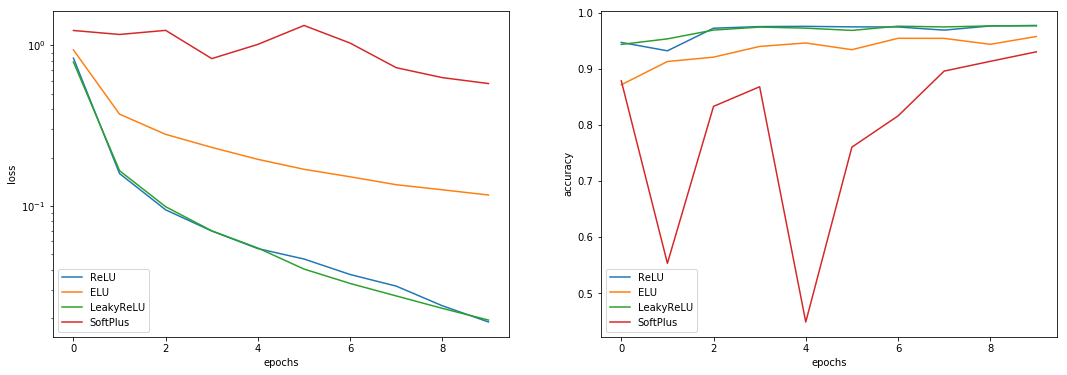

In [80]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.semilogy(relu_b,label='ReLU')
plt.semilogy(Elu_b,label='ELU')
plt.semilogy(LRelu_b,label='LeakyReLU')
plt.semilogy(Softplus_b,label='SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(relu_accuracy_b,label='ReLU')
plt.plot(elu_accuracy_b,label='ELU')
plt.plot(lrelu_accuracy_b,label='LeakyReLU')
plt.plot(softplus_accuracy_b,label='SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
print('ReLU loss: ',round(loss_relu_b,3),',', 'ReLU time: ',round(time_relu_b,3),',', 'ReLu accuracy: ', np.max(relu_accuracy_b))
print('ELU loss: ',round(loss_elu_b,3), ',','ELU time: ',round(time_elu_b,3), ',','ELU accuracy: ', np.max(elu_accuracy_b))
print('LeakyReLU loss: ',round(loss_lrelu_b,3),',','LeakyReLU time: ',round(time_lrelu_b,3),',', 'LeakyReLU accuracy',np.max(lrelu_accuracy_b))
print('SoftPlus loss: ',round(loss_softplus_b,3), ',','SoftPlus time: ',round(time_softplus_b,3),',', 'SoftPlus accuracy: ',np.max(softplus_accuracy_b) )

## Comparison with BatchNormalization and without

Text(0,0.5,'loss')

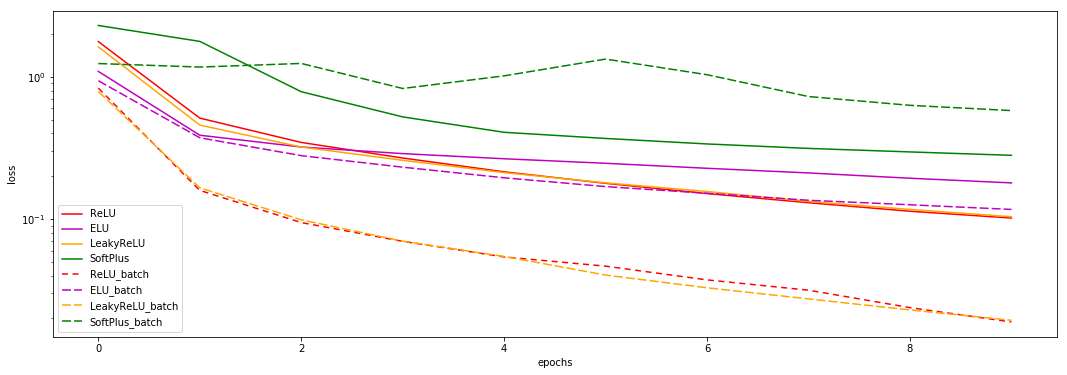

In [18]:
plt.figure(figsize=(18,6))
plt.semilogy(relu,c='r',label='ReLU')
plt.semilogy(Elu,c='m',label='ELU')
plt.semilogy(LRelu,c='orange',label='LeakyReLU')
plt.semilogy(Softplus,c='g',label='SoftPlus')
plt.semilogy(relu_b,c='r',dashes=[4, 3],label='ReLU_batch')
plt.semilogy(Elu_b,c='m',dashes=[6, 2],label='ELU_batch')
plt.semilogy(LRelu_b,c='orange',dashes=[6, 2],label='LeakyReLU_batch')
plt.semilogy(Softplus_b,c='g',dashes=[6, 2],label='SoftPlus_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')


Text(0,0.5,'loss')

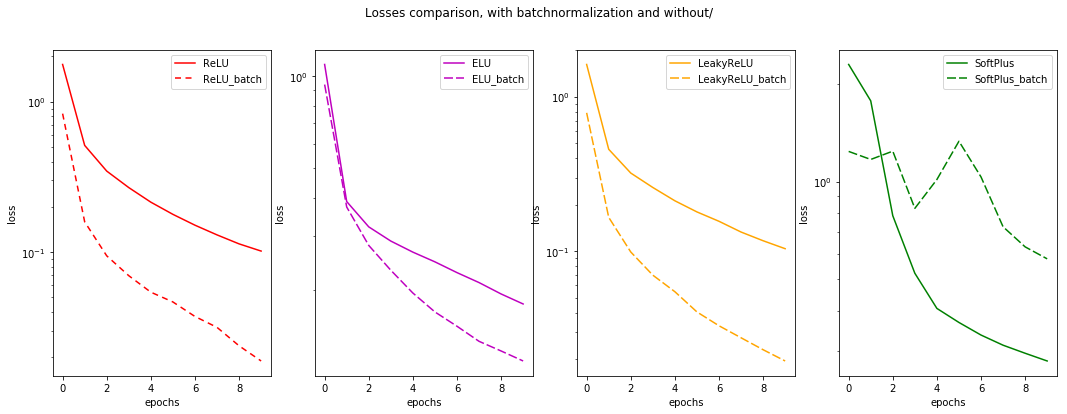

In [19]:
plt.figure(figsize=(18,6))
plt.suptitle('Losses comparison, with batchnormalization and without/')
plt.subplot(141)
plt.semilogy(relu,c='r',label='ReLU')
plt.semilogy(relu_b,c='r',dashes=[4, 3],label='ReLU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(142)
plt.semilogy(Elu,c='m',label='ELU')
plt.semilogy(Elu_b,c='m',dashes=[6, 2],label='ELU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(143)
plt.semilogy(LRelu,c='orange',label='LeakyReLU')
plt.semilogy(LRelu_b,c='orange',dashes=[6, 2],label='LeakyReLU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(144)
plt.semilogy(Softplus,c='g',label='SoftPlus')
plt.semilogy(Softplus_b,c='g',dashes=[6, 2],label='SoftPlus_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')



<function matplotlib.pyplot.show(*args, **kw)>

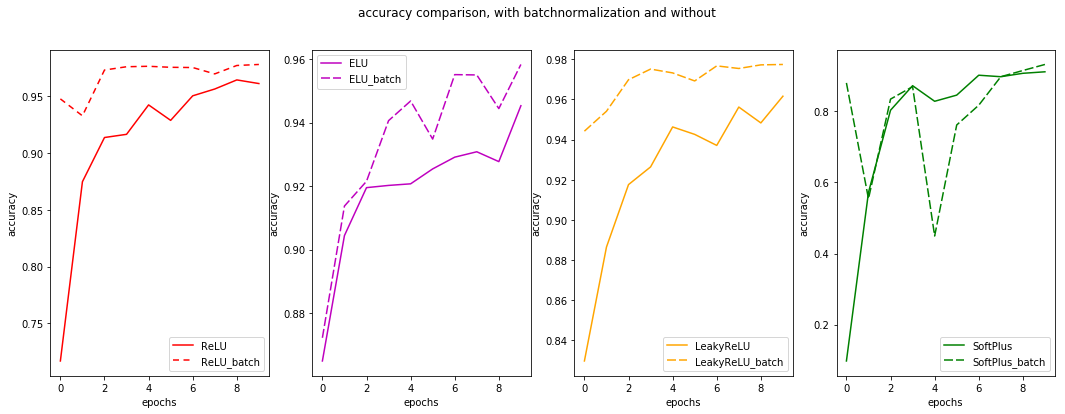

In [79]:
plt.figure(figsize=(18,6))
plt.suptitle('accuracy comparison, with batchnormalization and without')
plt.subplot(141)
plt.plot(relu_accuracy,c='r',label='ReLU')
plt.plot(relu_accuracy_b,c='r',dashes=[4, 3],label='ReLU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(142)
plt.plot(elu_accuracy,c='m',label='ELU')
plt.plot(elu_accuracy_b,c='m',dashes=[6, 2],label='ELU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(143)
plt.plot(lrelu_accuracy,c='orange',label='LeakyReLU')
plt.plot(lrelu_accuracy_b,c='orange',dashes=[6, 2],label='LeakyReLU_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(144)
plt.plot(softplus_accuracy,c='g',label='SoftPlus')
plt.plot(softplus_accuracy_b,c='g',dashes=[6, 2],label='SoftPlus_batch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show

as we can see, batchnormalization improve results of some functions,accuracy get better, and loss get smaller, as a result we can say, that yes, Batchnormalization improve results

## Comparison Momentum and Adam

In [21]:
def my_netty_adam(activation):
    loss_history = []
    accuracy=[]
    optimizer_config = {'learning_rate' : 1e-1 , 'beta1': 0.9,'beta2': 0.99,'epsilon':0.01}
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(activation())
    net.add(Linear(256, 128))
    net.add(activation())
    net.add(Linear(128, 64)) 
    net.add(activation())
    net.add(Linear(64, 10))
    net.add(LogSoftMax())
    

    criterion = ClassNLLCriterion()
    n_epoch = 10
    batch_size = 256
    time_begin = time()
    for i in range(n_epoch):
        loss_epoch=[]
#         accuracy_epoch=[]
        for x_batch, y_batch in get_batches((X_train, y_encoded), batch_size):    
            net.zeroGradParameters()


            optimizer_state = {}

                # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

                # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

                # Update weights
            adam_optimizer(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state) 
            
            loss_epoch.append(loss)
            #Accuracy calculation
        net.evaluate()
        y_pred=net.forward(X_test)
        test_loss=criterion.forward(y_pred,y_test_encoded)
        epoch_accuracy=accuracy_score(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred,axis=1))
        accuracy.append(epoch_accuracy)
        #accuracy_epoch.append(iter_accuracy)
        
            
#         accuracy.append(np.mean(accuracy_epoch))    
        loss_history.append(np.mean(loss_epoch))
    time_end = time()
    time_result=time_end-time_begin
            

    
    return loss_history,time_result,loss,accuracy

In [22]:
relu_adam,time_relu_adam,loss_relu_adam,relu_accuracy_adam=my_netty_adam(ReLU)
Elu_adam,time_elu_adam,loss_elu_adam,elu_accuracy_adam=my_netty_adam(ELU)
LRelu_adam,time_lrelu_adam,loss_lrelu_adam,lrelu_accuracy_adam=my_netty_adam(LeakyReLU)
Softplus_adam,time_softplus_adam,loss_softplus_adam,softplus_accuracy_adam=my_netty_adam(SoftPlus)

<function matplotlib.pyplot.show(*args, **kw)>

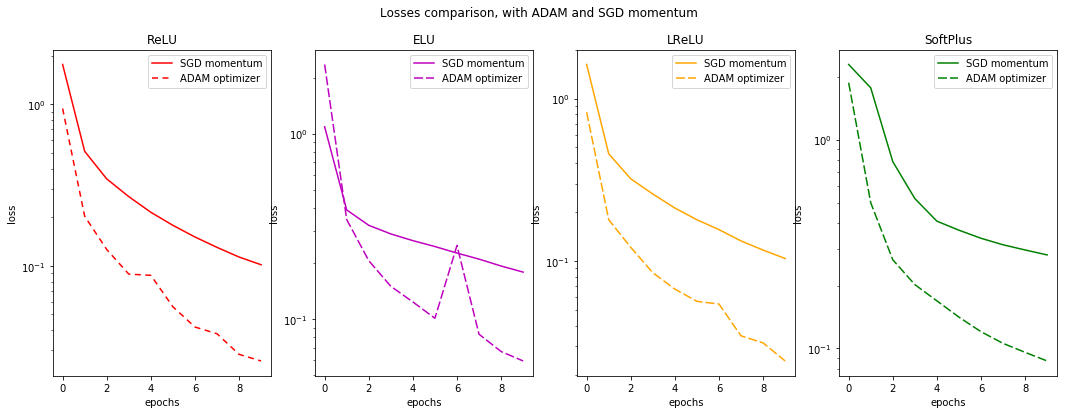

In [23]:
plt.figure(figsize=(18,6))
plt.suptitle('Losses comparison, with ADAM and SGD momentum')
plt.subplot(141)
plt.semilogy(relu,c='r',label='SGD momentum')
plt.semilogy(relu_adam,c='r',dashes=[4, 3],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ReLU')
plt.subplot(142)
plt.semilogy(Elu,c='m',label='SGD momentum')
plt.semilogy(Elu_adam,c='m',dashes=[6, 2],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ELU')
plt.subplot(143)
plt.semilogy(LRelu,c='orange',label='SGD momentum')
plt.semilogy(LRelu_adam,c='orange',dashes=[6, 2],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LReLU')
plt.subplot(144)
plt.semilogy(Softplus,c='g',label='SGD momentum')
plt.semilogy(Softplus_adam,c='g',dashes=[6, 2],label='ADAM optimizer')
plt.title('SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

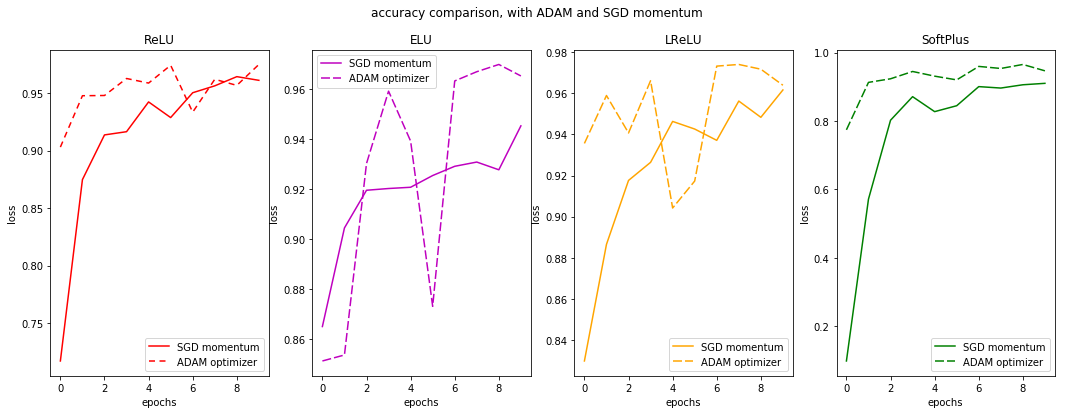

In [24]:
plt.figure(figsize=(18,6))
plt.suptitle('accuracy comparison, with ADAM and SGD momentum')
plt.subplot(141)
plt.plot(relu_accuracy,c='r',label='SGD momentum')
plt.plot(relu_accuracy_adam,c='r',dashes=[4, 3],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ReLU')
plt.subplot(142)
plt.plot(elu_accuracy,c='m',label='SGD momentum')
plt.plot(elu_accuracy_adam,c='m',dashes=[6, 2],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ELU')
plt.subplot(143)
plt.plot(lrelu_accuracy,c='orange',label='SGD momentum')
plt.plot(lrelu_accuracy_adam,c='orange',dashes=[6, 2],label='ADAM optimizer')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LReLU')
plt.subplot(144)
plt.plot(softplus_accuracy,c='g',label='SGD momentum')
plt.plot(softplus_accuracy_adam,c='g',dashes=[6, 2],label='ADAM optimizer')
plt.title('SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show

In [25]:
import pandas as pd
acc_sgd=[np.max(relu_accuracy),np.max(elu_accuracy),np.max(lrelu_accuracy),np.max(softplus_accuracy)]
acc_adam=[np.max(relu_accuracy_adam),np.max(elu_accuracy_adam),np.max(lrelu_accuracy_adam),np.max(softplus_accuracy_adam)]
loss_sgd=[loss_relu,loss_elu,loss_lrelu,loss_softplus]
loss_adam=[loss_relu_adam,loss_elu_adam,loss_lrelu_adam,loss_softplus_adam]
rows=['ReLU','ELU',"Leaky ReLU",'SoftPlus']
df = pd.DataFrame(list(zip(acc_sgd, acc_adam,loss_sgd,loss_adam)), 
               columns =['Momentum accuracy', 'ADAM accuracy','Momentum loss','Adam loss'],index=['ReLU','ELU',"Leaky ReLU",'SoftPlus'])
df

,Momentum accuracy,ADAM accuracy,Momentum loss,Adam loss
ReLU,0.9644,0.9750,0.154160,0.017010
ELU,0.9453,0.9699,0.142416,0.082562
Leaky ReLU,0.9616,0.9740,0.071568,0.012763
SoftPlus,0.9104,0.9656,0.388057,0.120795


As we can see, all outputs of ADAM is better then on momentum. the loss get smaller, and accuracy higher. moreover accuracy more 90% after 1st epoch

## Dropout

In [33]:
def my_netty_batch_drop(activation):
    loss_history = []
    loss_history_test = []
    accuracy_val=[]
    optimizer_config = {'learning_rate' : 1e-1 , 'momentum': 0.9}
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(activation())
    net.add(Dropout())
    net.add(Linear(256, 128))
    net.add(activation())
    net.add(Linear(128, 64))
    net.add(activation())
    net.add(Linear(64, 10))
    #net.add(activation())
    net.add(LogSoftMax())
   
    

    criterion = ClassNLLCriterion()
    n_epoch = 10
    batch_size = 256
    time_begin = time()
    for i in range(n_epoch):
        loss_epoch=[]
        for x_batch, y_batch in get_batches((X_train, y_encoded), batch_size):    
            net.zeroGradParameters()


            optimizer_state = {}

                # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

                # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

                # Update weights
            sgd_momentum(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state) 
            loss_epoch.append(loss)
        net.evaluate()
        y_pred=net.forward(X_test)
        y_pred_val=net.forward(X_val)
        test_loss=criterion.forward(y_pred,y_test_encoded)
        #epoch_accuracy=accuracy_score(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred,axis=1))
        epoch_accuracy_val=accuracy_score(np.argmax(y_val_encoded,axis=1),np.argmax(y_pred_val,axis=1))
        #accuracy_test.append(epoch_accuracy)
        accuracy_val.append(epoch_accuracy_val)
        loss_history.append(np.mean(loss_epoch))
        loss_history_test.append(test_loss)
        
    time_end = time()
    time_result=time_end-time_begin
            

    
    return loss_history,loss,accuracy_val,test_loss,loss_history_test

In [34]:
relu_b_d,loss_relu_b_d,relu_accuracy_val_b_d,relu_test_loss_d,relu_test_loss_dh=my_netty_batch_drop(ReLU)
elu_b_d,loss_elu_b_d,elu_accuracy_val_b_d,elu_test_loss_d,elu_test_loss_dh=my_netty_batch_drop(ELU)
Lrelu_b_d,loss_Lrelu_b_d,Lrelu_accuracy_val_b_d,Lrelu_test_loss_d,Lrelu_test_loss_dh=my_netty_batch_drop(LeakyReLU)
sf_b_d,loss_sf_b_d,sf_accuracy_val_b_d,sf_test_loss_d,sf_test_loss_dh=my_netty_batch_drop(SoftPlus)

In [35]:
def my_netty_batch_(activation):
    loss_history = []
    loss_history_test = []
    accuracy_val=[]
    optimizer_config = {'learning_rate' : 1e-1 , 'momentum': 0.9}
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(activation())
    net.add(Dropout())
    net.add(Linear(256, 128))
    net.add(activation())
    net.add(Linear(128, 64))
    net.add(activation())
    net.add(Linear(64, 10))
    #net.add(activation())
    net.add(LogSoftMax())
   
    

    criterion = ClassNLLCriterion()
    n_epoch = 10
    batch_size = 256
    time_begin = time()
    for i in range(n_epoch):
        loss_epoch=[]
        for x_batch, y_batch in get_batches((X_train, y_encoded), batch_size):    
            net.zeroGradParameters()


            optimizer_state = {}

                # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

                # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

                # Update weights
            sgd_momentum(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state) 
            loss_epoch.append(loss)
        net.evaluate()
        y_pred=net.forward(X_test)
        y_pred_val=net.forward(X_val)
        test_loss=criterion.forward(y_pred,y_test_encoded)
        #epoch_accuracy=accuracy_score(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred,axis=1))
        epoch_accuracy_val=accuracy_score(np.argmax(y_val_encoded,axis=1),np.argmax(y_pred_val,axis=1))
        #accuracy_test.append(epoch_accuracy)
        accuracy_val.append(epoch_accuracy_val)
        loss_history.append(np.mean(loss_epoch))
        loss_history_test.append(test_loss)
        
    time_end = time()
    time_result=time_end-time_begin
            

    
    return loss_history,loss,accuracy_val,test_loss,loss_history_test
            


In [36]:
relu_b_,loss_relu_b_,relu_accuracy_val_b_,relu_test_loss_,relu_test_loss_h=my_netty_batch_(ReLU)
elu_b_,loss_elu_b_,elu_accuracy_val_b_,elu_test_loss_,elu_test_loss_h=my_netty_batch_(ELU)
Lrelu_b_,loss_Lrelu_b_,Lrelu_accuracy_val_b_,Lrelu_test_loss_,Lrelu_test_loss_h=my_netty_batch_(LeakyReLU)
sf_b_,loss_sf_b_,sf_accuracy_val_b_,sf_test_loss_,sf_test_loss_h=my_netty_batch_(SoftPlus)

## comparison with dropout and without

<function matplotlib.pyplot.show(*args, **kw)>

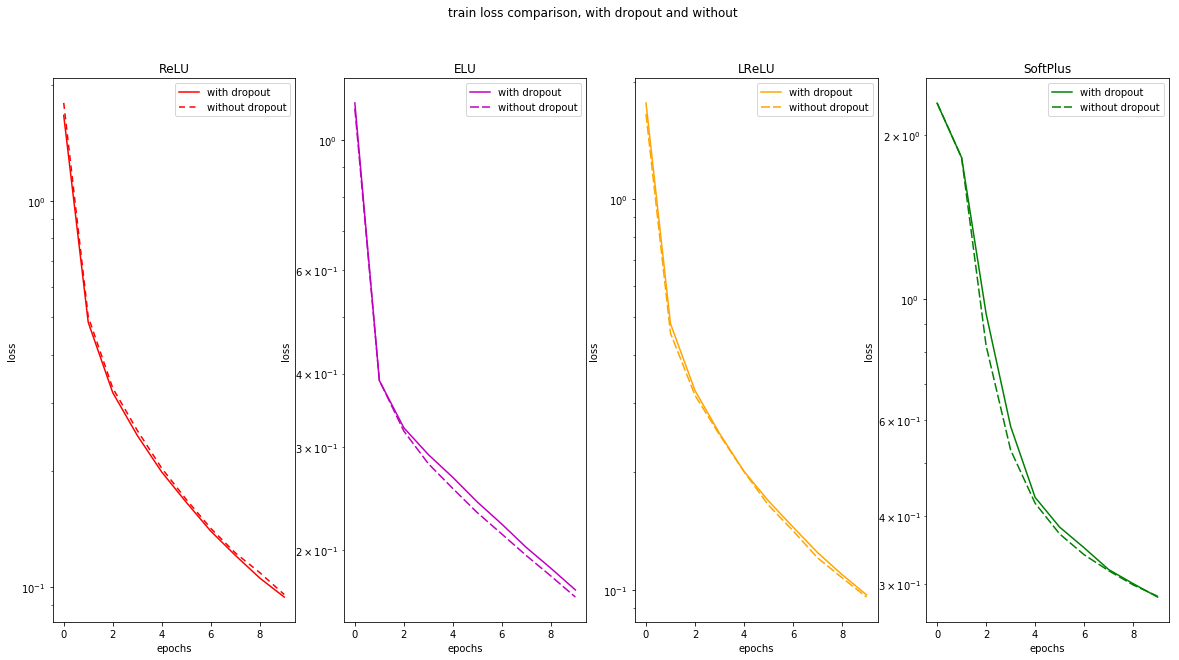

In [37]:
plt.figure(figsize=(20,10))
plt.suptitle('train loss comparison, with dropout and without')
plt.subplot(141)
plt.semilogy(relu_b_d,c='r',label='with dropout')
plt.semilogy(relu_b_,c='r',dashes=[4, 3],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ReLU')
plt.subplot(142)
plt.semilogy(elu_b_d,c='m',label='with dropout')
plt.semilogy(elu_b_,c='m',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ELU')
plt.subplot(143)
plt.semilogy(Lrelu_b_d,c='orange',label='with dropout')
plt.semilogy(Lrelu_b_,c='orange',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LReLU')
plt.subplot(144)
plt.semilogy(sf_b_d,c='g',label='with dropout')
plt.semilogy(sf_b_,c='g',dashes=[6, 2],label='without dropout')
plt.title('SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

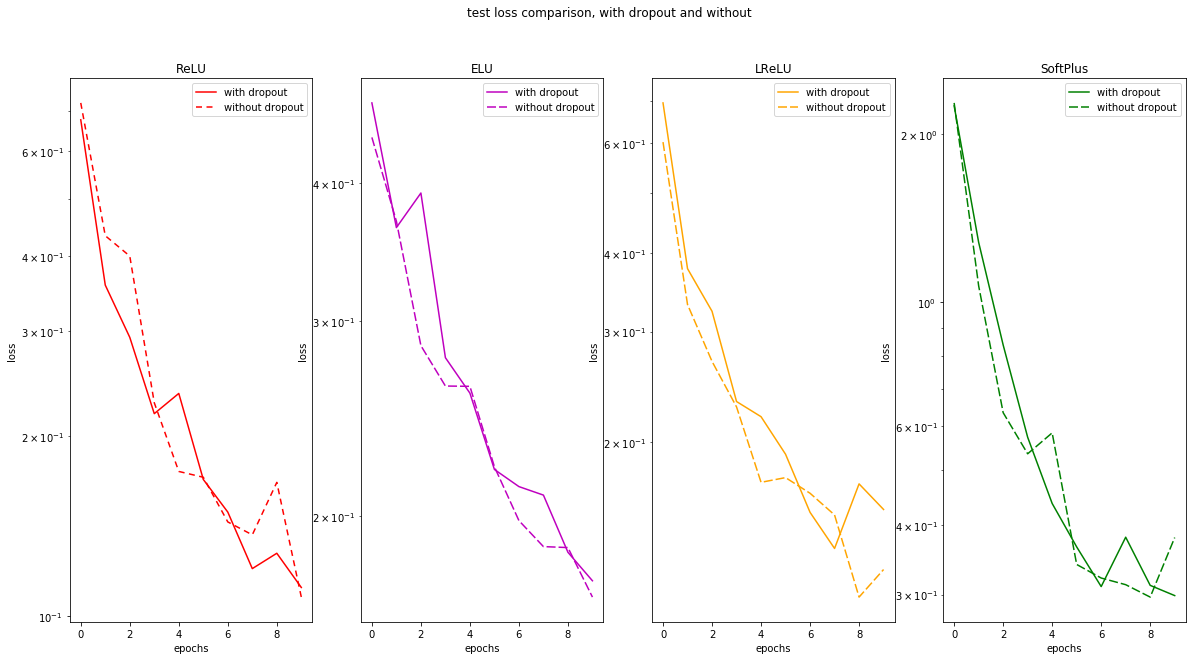

In [90]:
plt.figure(figsize=(20,10))
plt.suptitle('test loss comparison, with dropout and without')
plt.subplot(141)
plt.semilogy(relu_test_loss_dh,c='r',label='with dropout')
plt.semilogy(relu_test_loss_h,c='r',dashes=[4, 3],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ReLU')
plt.subplot(142)
plt.semilogy(elu_test_loss_dh,c='m',label='with dropout')
plt.semilogy(elu_test_loss_h,c='m',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ELU')
plt.subplot(143)
plt.semilogy(Lrelu_test_loss_dh,c='orange',label='with dropout')
plt.semilogy(Lrelu_test_loss_h,c='orange',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LReLU')
plt.subplot(144)
plt.semilogy(sf_test_loss_dh,c='g',label='with dropout')
plt.semilogy(sf_test_loss_h,c='g',dashes=[6, 2],label='without dropout')
plt.title('SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

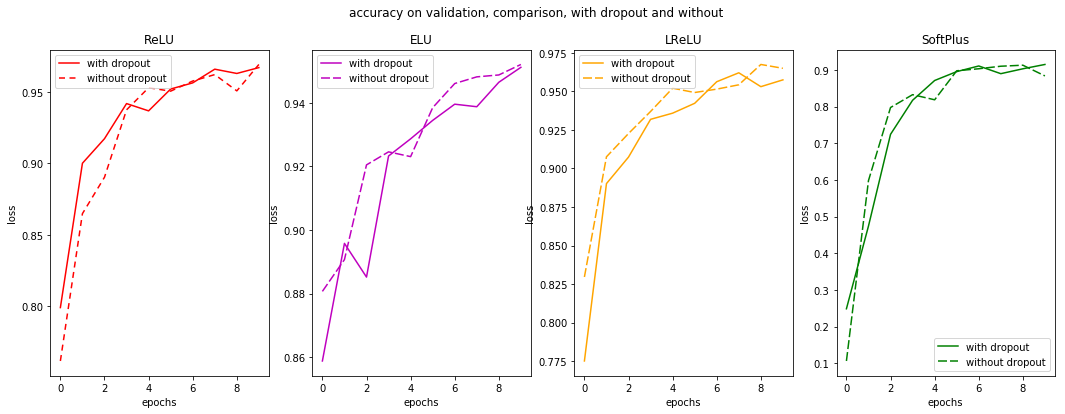

In [39]:
plt.figure(figsize=(18,6))
plt.suptitle('accuracy on validation, comparison, with dropout and without')
plt.subplot(141)
plt.plot(relu_accuracy_val_b_d,c='r',label='with dropout')
plt.plot(relu_accuracy_val_b_,c='r',dashes=[4, 3],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ReLU')
plt.subplot(142)
plt.plot(elu_accuracy_val_b_d,c='m',label='with dropout')
plt.plot(elu_accuracy_val_b_,c='m',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ELU')
plt.subplot(143)
plt.plot(Lrelu_accuracy_val_b_d,c='orange',label='with dropout')
plt.plot(Lrelu_accuracy_val_b_,c='orange',dashes=[6, 2],label='without dropout')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LReLU')
plt.subplot(144)
plt.plot(sf_accuracy_val_b_d,c='g',label='with dropout')
plt.plot(sf_accuracy_val_b_,c='g',dashes=[6, 2],label='without dropout')
plt.title('SoftPlus')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show

In [55]:
train_loss_d=[loss_relu_b_d,loss_elu_b_d,loss_Lrelu_b_d,loss_sf_b_d]
test_loss_d=[relu_test_loss_d,elu_test_loss_d,Lrelu_test_loss_d,sf_test_loss_d]

train_loss_=[loss_relu_b_,loss_elu_b_,loss_Lrelu_b_,loss_sf_b_]
test_loss_=[relu_test_loss_,elu_test_loss_,Lrelu_test_loss_,sf_test_loss_]


acc_without_d_v=[np.max(relu_accuracy_val_b_d),np.max(elu_accuracy_val_b_d),np.max(Lrelu_accuracy_val_b_d),np.max(sf_accuracy_val_b_d)]
acc_drop_val=[np.max(relu_accuracy_val_b_),np.max(elu_accuracy_val_b_),np.max(Lrelu_accuracy_val_b_),np.max(sf_accuracy_val_b_)]



In [57]:
rows=['ReLU','ELU',"Leaky ReLU",'SoftPlus']
df = pd.DataFrame(list(zip(train_loss_d, test_loss_d,(np.array(train_loss_d)-np.array(test_loss_d)),train_loss_,test_loss_,(np.array(train_loss_)-np.array(test_loss_)),acc_without_d_v,acc_drop_val)), 
               columns =['Train Loss with Do', 'Test Loss with DO','Gap','Train Loss without DO','Test Loss without DO','Gap','accuracy with DO','accuracy without DO'],index=['ReLU','ELU',"Leaky ReLU",'SoftPlus'])
df

,Train Loss with Do,Test Loss with DO,Gap,Train Loss without DO,Test Loss without DO,Gap,accuracy with DO,accuracy without DO
ReLU,0.134848,0.111659,0.023188,0.060982,0.107598,-0.046616,0.9671,0.9693
ELU,0.137567,0.174677,-0.037111,0.142917,0.168841,-0.025925,0.9512,0.9521
Leaky ReLU,0.104568,0.155941,-0.051373,0.078202,0.125036,-0.046834,0.9621,0.9675
SoftPlus,0.252791,0.298689,-0.045898,0.206891,0.379271,-0.172379,0.9146,0.9126


So as we can see, from graphs over, train losses converges almost the same, but test losses look differents, ReLu and ELU converges better.
Gap: the better result in ReLU with Drop out

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [89]:

loss_history = []    
optimizer_config = {'learning_rate' : 1e-7 , 'momentum': 0.8}
net = Sequential()
net.add(Linear(784, 256))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(256, 128))
net.add(ReLU())
net.add(Linear(128, 10))
    #net.add(activation())
#net.add(LogSoftMax())

       
criterion = ClassContrastiveCriterion(5)
n_epoch = 10
batch_size = 10
for i in range(n_epoch):
    loss_epoch=[]
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):    
        net.zeroGradParameters()
        optimizer_state = {}
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
          # Backwar
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

                # Update weights
        sgd_momentum(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state) 
        loss_epoch.append(loss)
    net.evaluate()
    net.forward(X_val)
    
    loss_history.append(np.mean(loss_epoch))
    
        
                

    


C:\Users\nikos\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\nikos\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
#features : 'number of examples' * 'dimensionality'
f = net[-1].output

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))

In [ ]:
ELU()